In [1]:
import requests
import pandas as pd
import time

datajson = requests.get('http://umbrel.local:3006/api/v1/blocks/')
#time.sleep(5) #OPTIONAL: I recommend that you put a 5 second sleep here if you're pinging other peoples' servers. Since we hit a mempool.space instance run on an Umbrel locally I think we are OK here.
datapd = pd.DataFrame(datajson.json())

def generatePoolFeeDF(dataframe):
    blocks = []
    pools = []
    fees = []
    timestamps = []

    i=0

    while i < len(datapd):
        bl = dataframe.iloc[i]['height']
        blocks.append(bl)
    
        pool = dataframe.iloc[i]['extras']['pool']['name']
        pools.append(pool)
    
        fee = dataframe.iloc[i]['extras']['totalFees']/100000000
        fees.append(fee)
        
        times = dataframe.iloc[i]['timestamp']
        timestamps.append(times)
    
        i+=1

    df = pd.DataFrame()
    df['BlockHeight'] = blocks
    df['Pool'] = pools
    df['Fee (BTC)'] = fees
    df['timestamp'] = timestamps
    
    return df

frame = generatePoolFeeDF(datapd)

base_url = 'http://umbrel.local:3006/api/v1/blocks/{}'

i = 0
while i < 134:
    next_Block = frame.iloc[-1]['BlockHeight']-1
    new_url = base_url.format(next_Block)
    datajson = requests.get(new_url)
    #time.sleep(5)  #If you want to sleep between calls, un-hashtag this.
    temp_dataframe = pd.DataFrame(datajson.json())
    
    df_to_be_added = generatePoolFeeDF(temp_dataframe)
    frame = pd.concat([frame, df_to_be_added], ignore_index=True, sort=False)
    
    i+=1

Average fee across all pools: 0.5633989187901234
Median fee across all pools: 0.51622186
Average fee per pool:
Pool
ULTIMUSPOOL     0.660862
Luxor           0.632626
BTC.com         0.618865
F2Pool          0.616484
EMCDPool        0.615715
SBI Crypto      0.606259
AntPool         0.586729
Poolin          0.568885
ViaBTC          0.560754
Binance Pool    0.554831
Foundry USA     0.553494
MARA Pool       0.535453
Braiins Pool    0.534581
Unknown         0.507947
KuCoinPool      0.497415
PEGA Pool       0.401626
Solo CK         0.249077
Name: Fee (BTC), dtype: float64

Median fee per pool:
Pool
ULTIMUSPOOL     0.627388
SBI Crypto      0.590404
Luxor           0.557421
Poolin          0.549844
AntPool         0.526364
Braiins Pool    0.521507
ViaBTC          0.521215
F2Pool          0.519994
KuCoinPool      0.516577
BTC.com         0.515771
EMCDPool        0.515283
Foundry USA     0.514651
Binance Pool    0.501541
Unknown         0.479293
MARA Pool       0.447603
PEGA Pool       0.355772


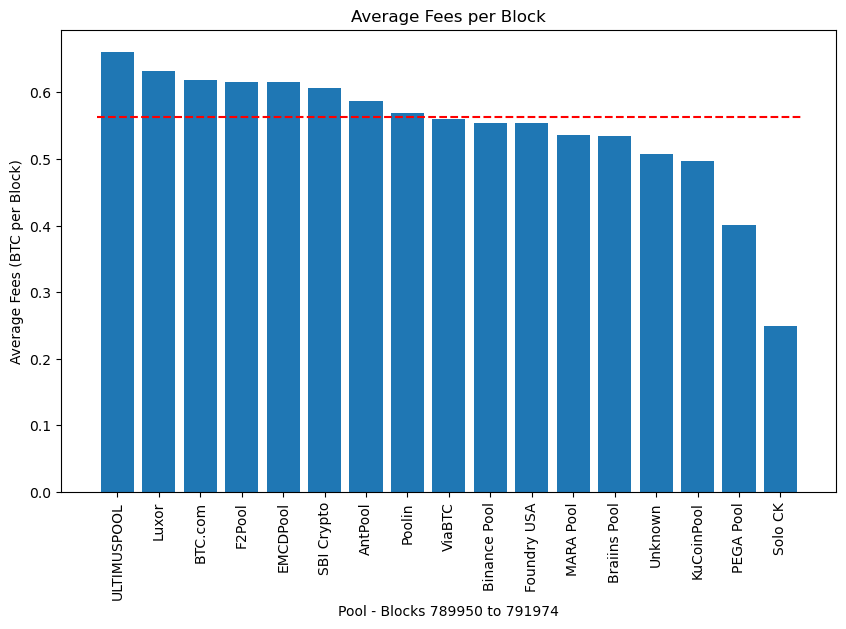

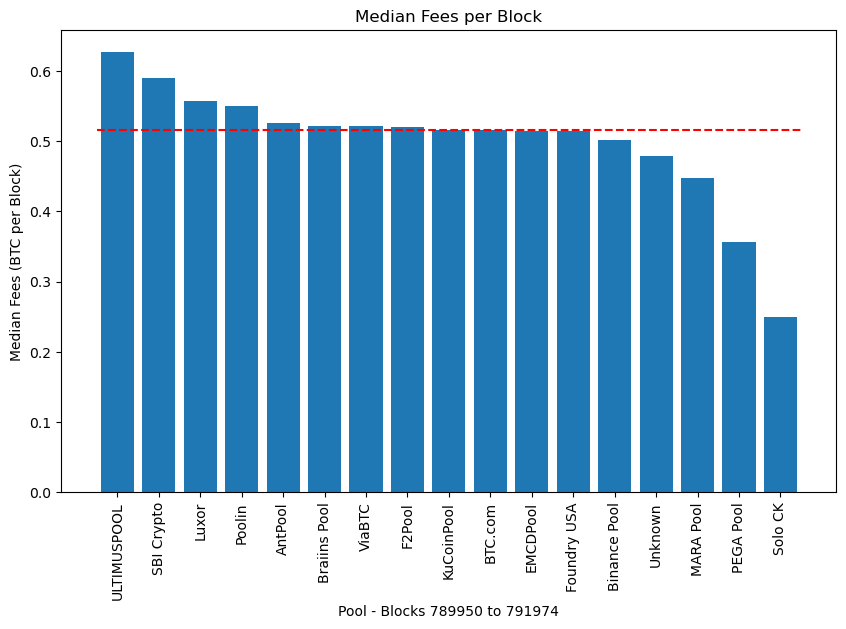

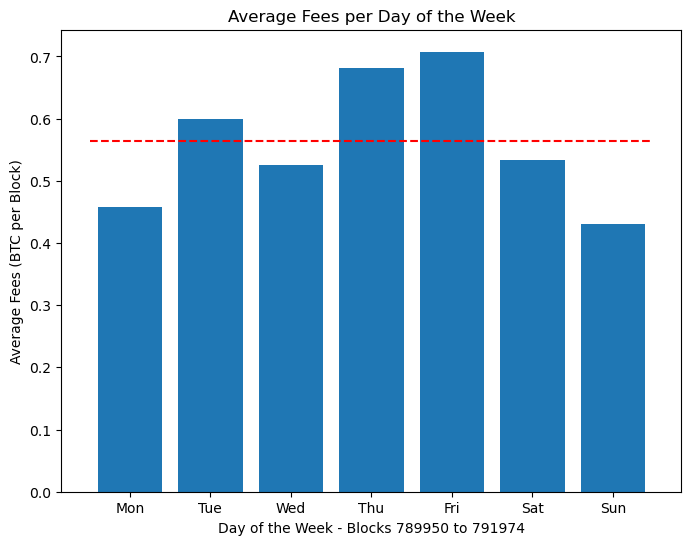

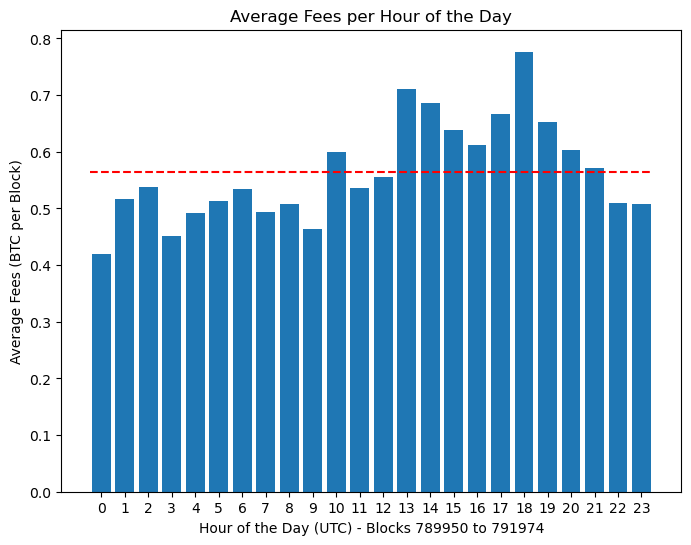

In [2]:
import matplotlib.pyplot as plt
start = frame['BlockHeight'][2024]
end = frame['BlockHeight'][0]
median_fee = frame['Fee (BTC)'].median()
average_fee = frame['Fee (BTC)'].mean()

print("Average fee across all pools:", average_fee)
print("Median fee across all pools:", median_fee)

grouped_data = frame.groupby('Pool')
average_fee_per_pool = grouped_data['Fee (BTC)'].mean().sort_values(ascending=False)
median_fee_per_pool = grouped_data['Fee (BTC)'].median().sort_values(ascending=False)

print("Average fee per pool:")
print(average_fee_per_pool)
print("\nMedian fee per pool:")
print(median_fee_per_pool)

plt.figure(figsize=(10, 6))
plt.bar(average_fee_per_pool.index, average_fee_per_pool)
plt.plot([-0.5, len(average_fee_per_pool) - 0.5], [average_fee, average_fee], color='red', linestyle='--', label='Average Across All Pools')
plt.xlabel(f'Pool - Blocks {start} to {end}')
plt.ylabel('Average Fees (BTC per Block)')
plt.title('Average Fees per Block')
plt.xticks(rotation=90)
plt.show()

# Plotting median fees per pool
plt.figure(figsize=(10, 6))
plt.bar(median_fee_per_pool.index, median_fee_per_pool)
plt.plot([-0.5, len(median_fee_per_pool) - 0.5], [median_fee, median_fee], color='red', linestyle='--', label='Median Across All Pools')
plt.xlabel(f'Pool - Blocks {start} to {end}')
plt.ylabel('Median Fees (BTC per Block)')
plt.title('Median Fees per Block')
plt.xticks(rotation=90)
plt.show()

frame['timestamp'] = pd.to_datetime(frame['timestamp'], unit='s')

# Extract day of the week and hour from the 'timestamp' column
frame['DayOfWeek'] = frame['timestamp'].dt.dayofweek
frame['Hour'] = frame['timestamp'].dt.hour

# Calculate average fees per day of the week
avg_fees_per_day = frame.groupby('DayOfWeek')['Fee (BTC)'].mean()

# Calculate average fees per hour of the day
avg_fees_per_hour = frame.groupby('Hour')['Fee (BTC)'].mean()

# Calculate overall average fee
overall_avg_fee = frame['Fee (BTC)'].mean()

# Plotting average fees per day of the week
plt.figure(figsize=(8, 6))
plt.bar(avg_fees_per_day.index, avg_fees_per_day)
plt.plot([-0.5, 6.5], [overall_avg_fee, overall_avg_fee], color='red', linestyle='--', label='Overall Average')
plt.xlabel(f'Day of the Week - Blocks {start} to {end}')
plt.ylabel('Average Fees (BTC per Block)')
plt.title('Average Fees per Day of the Week')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

# Plotting average fees per hour of the day
plt.figure(figsize=(8, 6))
plt.bar(avg_fees_per_hour.index, avg_fees_per_hour)
plt.plot([-0.5, 23.5], [overall_avg_fee, overall_avg_fee], color='red', linestyle='--', label='Overall Average')
plt.xlabel(f'Hour of the Day (UTC) - Blocks {start} to {end}')
plt.ylabel('Average Fees (BTC per Block)')
plt.title('Average Fees per Hour of the Day')
plt.xticks(range(24))
plt.show()